In [1]:
import pandas as pd
import numpy as np
import sys

from utils import *

target='top20'

df= pd.read_csv('../dataset/full_aggregated.csv',index_col=0)
df['top20'] = df['position'].apply(lambda x: 1 if x <= 0.162 else 0)
df = df.drop([
                'position',
                'is_tarmac',
                'day',
                'nationality', 
                'cyclist_id',
                '_url',
                'date',
                'cyclist_team', 
                'race_name',
                # 'month',
             ],axis=1)

cat_le=[
            'nationality', 
            'cyclist_id',
            '_url',
            'date',
            'cyclist_team', 
            'race_name',
            'month',
            'day',]
cat_le = [ x for x in cat_le if x in df.columns]
d=DataUtil(df, cat_le=cat_le,
        cat_oe=[
            'race_category'
        ],
        bins = [
            'top20'
        ])


train,valid,test=d.get_classic_numerical()
train.shape,valid.shape,test.shape


ModuleNotFoundError: No module named 'torch'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# # Get cpu, gpu or mps device for training.
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )

device = "cpu"
print(f"Using {device} device")




class CyclistDataset(Dataset):
    def __init__(self, X_cat, X_num, y):
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

# Create datasets and dataloaders
train_loader = DataLoader(CyclistDataset(X_cat_train, X_num_train, y_train), batch_size=128, shuffle=True)
valid_loader = DataLoader(CyclistDataset(X_cat_valid, X_num_valid, y_valid), batch_size=128, shuffle=False)


class CyclistNN(nn.Module):
    def __init__(self, num_categories, embedding_dims, num_numerical_features, hidden_dim=128):
        super(CyclistNN, self).__init__()
        
        # Embedding layers for categorical features with respective dimensions
        self.embeddings = nn.ModuleList(
            [nn.Embedding(num_categories[i], embedding_dims[i]) for i in range(len(num_categories))]
        )

        # Calculate the total input size for linear layers
        input_size = sum(embedding_dims) + num_numerical_features
        
        # Linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Added additional hidden layer
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(.3)  # Slightly increased dropout for regularization
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, X_cat, X_num):
        # Process categorical features through embeddings
        x_cat = torch.cat([embed(X_cat[:, i]) for i, embed in enumerate(self.embeddings)], dim=1)
        
        # Concatenate embeddings with numerical features
        x = torch.cat([x_cat, X_num], dim=1)
        
        # Pass through the network layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return self.sigmoid(x)



    
    
    # Calculate number of unique categories for each categorical column
num_categories = d.num_cat()

# Calculate embedding dimensions based on the number of unique categories
embedding_dims = [min(50, int(np.log(n_cat // 2))+1) for n_cat in num_categories]

# Initialize model with calculated embedding dimensions
model = CyclistNN(num_categories=num_categories, embedding_dims=embedding_dims, num_numerical_features=len(num)).to(device)



Using cpu device


Epoch 1 - Training Loss: 0.3674, Validation Loss: 0.3375
Epoch 2 - Training Loss: 0.3286, Validation Loss: 0.3191
Epoch 3 - Training Loss: 0.3150, Validation Loss: 0.3116
Epoch 4 - Training Loss: 0.3077, Validation Loss: 0.3078
Epoch 5 - Training Loss: 0.3032, Validation Loss: 0.3105
Epoch 6 - Training Loss: 0.2993, Validation Loss: 0.3101
Epoch 7 - Training Loss: 0.2970, Validation Loss: 0.3061
Epoch 8 - Training Loss: 0.2942, Validation Loss: 0.3048
Epoch 9 - Training Loss: 0.2925, Validation Loss: 0.3065
Epoch 10 - Training Loss: 0.2906, Validation Loss: 0.3070
Epoch 11 - Training Loss: 0.2894, Validation Loss: 0.3058
Epoch 12 - Training Loss: 0.2881, Validation Loss: 0.3100
Epoch 13 - Training Loss: 0.2863, Validation Loss: 0.3115
Epoch 14 - Training Loss: 0.2853, Validation Loss: 0.3134
Epoch 15 - Training Loss: 0.2837, Validation Loss: 0.3078
Epoch 16 - Training Loss: 0.2831, Validation Loss: 0.3091
Epoch 17 - Training Loss: 0.2821, Validation Loss: 0.3070
Epoch 18 - Training Los

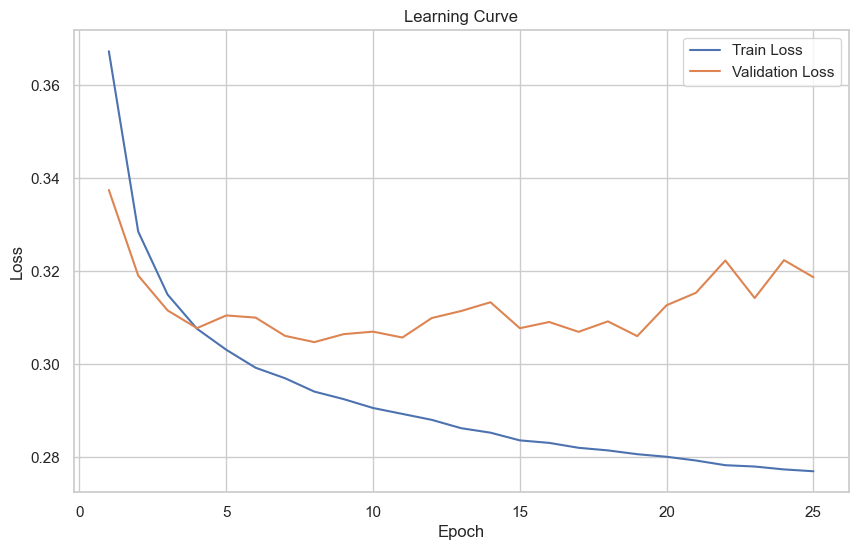

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=.005)

# Containers for loss values
train_losses = []
val_losses = []

n_epochs=25
# Training Loop
for epoch in range(n_epochs):  # Number of epochs
    model.train()
    train_loss = 0

    for X_cat_batch, X_num_batch, y_batch in train_loader:
        X_cat_batch = X_cat_batch.to(device)
        X_num_batch = X_num_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_num_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss over the training batches
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_cat_batch, X_num_batch, y_batch in valid_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_cat_batch, X_num_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plotting the learning curve
epochs = list(range(1, n_epochs + 1))
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=train_losses, label='Train Loss')
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Accuracy: 0.88
Precision: 0.65
Recall: 0.33
MCC: 0.40
ROC AUC: 0.65


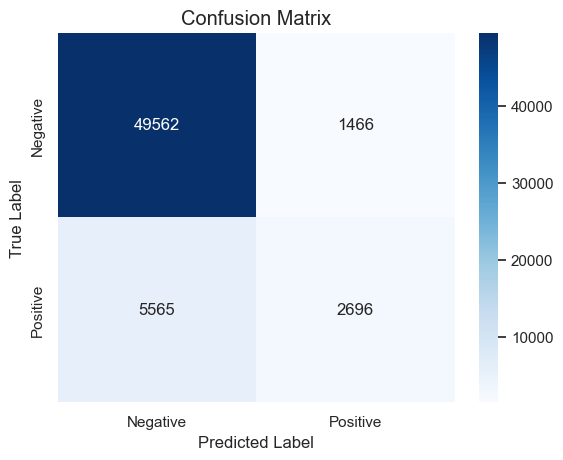

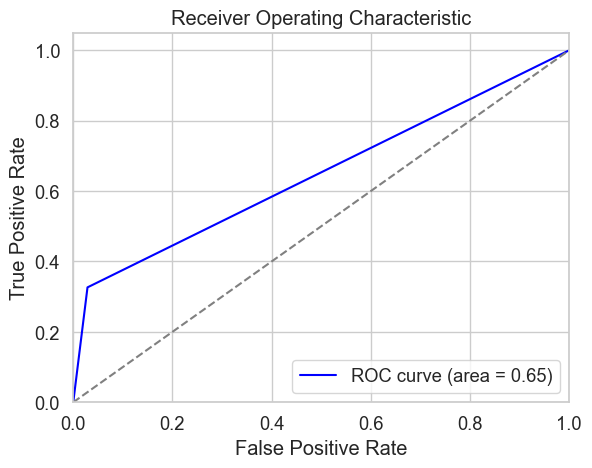

In [5]:
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    roc_curve, roc_auc_score, matthews_corrcoef
)

# Assuming test_df is loaded and contains test data
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for X_cat_batch, X_num_batch, y_batch in test_loader:
            outputs = model(X_cat_batch, X_num_batch).squeeze()
            preds = (outputs > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy().astype(int))

    return np.array(all_labels), np.array(all_preds)

# Replace test_loader with your DataLoader for test_df
all_labels, all_preds = evaluate_model(model, valid_loader)

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
mcc = matthews_corrcoef(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"MCC: {mcc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot Confusion Matrix using Seaborn
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)
sns.set_context('notebook', font_scale=1.2)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve using Seaborn
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.2f})', color="blue")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color="gray")
sns.set_context('notebook', font_scale=1.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
